# Projet 10 — PDP & ICE avancés

Objectif: entraîner un modèle non linéaire puissant, tracer des courbes PDP et ICE sur 2–3 variables clés et montrer comment le PDP (moyenne globale) peut masquer des hétérogénéités locales que l’ICE révèle.

---

## Plan rapide

1) Charger un dataset tabulaire (ex: Adult Income via OpenML).  
2) Prétraiter (One-Hot pour catégorielles, imputation).  
3) Entraîner un modèle non linéaire (Random Forest, Gradient Boosting, XGBoost).  
4) Identifier 2–3 variables clés (importance/permutation, SHAP en option).  
5) Tracer:
   - PDP 1D (moyenne) et ICE 1D (courbes individuelles) pour chaque variable,
   - PDP 2D pour au moins une paire pour voir les interactions,
   - Option: ICE centré (c-ICE) et ICE coloré par une autre variable pour mettre en évidence l’hétérogénéité.
6) Interpréter et documenter les comportements moyens vs individuels.

Message à faire passer: le PDP, parce qu’il moyenne, peut lisser ou masquer des effets hétérogènes; l’ICE les rend visibles (changements de pente, sous-groupes, seuils).

---

## Dataset proposé

- Adult Income (classification binaire: >50K$): accessible directement via scikit-learn/OpenML; riche en variables numériques et catégorielles, avec interactions plausibles (âge × heures, éducation × heures, etc.).

Alternatives:
- California Housing (régression) pour un exemple purement numérique.
- Ames Housing (régression) via OpenML si vous préférez un « House Prices » libre (évite Kaggle).

Ci-dessous, un flux de travail complet sur Adult Income.

---

## Implémentation (Python)

Pré-requis: scikit-learn ≥ 1.1, matplotlib, pandas, numpy.  
Optionnel: xgboost si vous préférez XGBoost.


### 2) Choisir 2–3 variables clés

Option 1 (rapide): permutation importance sur l’échantillon de test.

Variables souvent intéressantes sur Adult: "age", "hours-per-week", "education-num".  
Nous allons les utiliser pour PDP/ICE.

### 3) PDP et ICE 1D

Lecture:
- La courbe épaisse = PDP (effet moyen conditionnel).  
- Les nombreuses courbes fines = ICE (variations au niveau de chaque individu, toutes choses égales par ailleurs sur la grille de la feature).

### 4) PDP 2D (interactions)

Lecture:
- Les cartes 2D et les courbes de niveau révèlent des interactions (ex: l’effet des heures dépend du niveau d’éducation).

### 5) ICE centré et hétérogénéité par sous-groupes (c-ICE + coloration)

Le centrage met en évidence les différences de pente plutôt que les niveaux.

Lecture:
- Si les moyennes par quantile d’éducation divergent nettement, l’effet des heures est hétérogène selon l’éducation (interaction implicite).  
- Le PDP 1D pouvait être lisse, mais les c-ICE révèlent des différences de pente/seuils entre sous-groupes.

---

## Interprétation attendue (exemples)

- education-num: généralement effet croissant sur P(>50K$).  
- hours-per-week: augmentation jusqu’à ~40–45h, puis parfois plateau ou rendements décroissants.  
- age: effets non linéaires (pente plus forte au début de carrière, puis stabilisation).

Interactions probables:
- education-num × hours-per-week: le gain marginal d’une heure peut être plus fort aux niveaux d’éducation élevés.  
- age × hours-per-week: les heures supplémentaires peuvent « payer » différemment selon l’âge.

Note: Ce sont des tendances typiques; vérifiez vos tracés pour votre entraînement précis.

---

## Points de vigilance

- Corrélation forte ou parfaite: évitez de garder à la fois "education" (texte) et "education-num".  
- Extrapolation de distribution: PDP/ICE évaluent sur une grille qui peut combiner des valeurs rarement observées conjointement (risque si variables très corrélées).  
  - Mitigation: restreindre la grille à des quantiles observés; inspecter des ICE par sous-groupes.  
- Causalité: PDP/ICE décrivent le modèle, pas le monde réel. Effets « what-if » restent associatifs.  
- Échelle et classe minoritaire: pour la classification, vérifiez le score (ROC-AUC, PR-AUC) et l’équilibre de classes.  
- Stabilité: utilisez un seed; répétez/réplication sur d’autres splits.

---

## Variantes et bonus

- ALE (Accumulated Local Effects): moins sensible à la corrélation; à présenter comme complément au PDP.  
- SHAP interaction values: pour quantifier et trier des interactions à montrer ensuite en PDP 2D.  
- Monotonicité/contraintes (XGBoost/LightGBM): tester l’impact sur les formes PDP/ICE.

---

## Deliverables (conseillés)

- Notebook propre:
  - Données, prétraitement, métriques,
  - Choix des 2–3 variables clés,
  - Figures: PDP/ICE 1D, c-ICE coloré, PDP 2D,
  - Commentaires courts sous chaque figure (2–4 phrases) avec la morale: PDP vs ICE.  
- Une slide de synthèse:
  - 1 figure PDP vs ICE côte à côte,
  - 1 carte PDP 2D d’interaction,
  - 3 bullet points: « ce que le PDP dit », « ce que l’ICE révèle », « pourquoi l’interaction compte ».


---

## En une phrase

- PDP résume l’effet moyen du modèle; ICE montre la diversité des comportements individuels.  
- Conclusion à illustrer: « Le PDP peut lisser des effets hétérogènes que l’ICE (et c-ICE) met en évidence, et les PDP 2D confirment les interactions responsables de ces hétérogénéités. »

# Chargement et préparation


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# 1) Charger Adult Income
adult = fetch_openml(name="adult", as_frame=True)
df = adult.frame.copy()

# Cible binaire: 1 si >50K
y = (df["class"] == ">50K").astype(int)
X = df.drop(columns=["class"])

# IMPORTANT: 'education' (texte) et 'education-num' (numérique) sont redondants (corrélation ~1).
# Gardons 'education-num' et supprimons 'education' pour éviter la fuite d'information.
if "education" in X.columns:
    X = X.drop(columns=["education"])

# Explicitly convert columns that should be numeric but might be object type
numeric_like_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Use .columns to check the actual names in X after dropping 'class' and 'education'
# The permutation importance output shows 'capitalgain', 'capitalloss', 'hoursperweek'
# Let's adjust numeric_like_cols based on observed column names.
# This assumes column names are consistent: age, fnlwgt, education-num, capitalgain, capitalloss, hoursperweek
actual_numeric_cols_in_X = ['age', 'fnlwgt', 'education-num', 'capitalgain', 'capitalloss', 'hoursperweek']

for col in actual_numeric_cols_in_X:
    if col in X.columns:
        # Convert to numeric, coercing errors to NaN, which SimpleImputer can then handle
        X[col] = pd.to_numeric(X[col], errors='coerce')

# 2) Colonnes numériques / catégorielles
# Re-select after conversion to ensure correct dtypes
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# 3) Prétraitements
num_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pour scikit-learn >=1.2, utilisez sparse_output=False (sinon 'sparse=False')
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer([
    ("num", num_pre, num_cols),
    ("cat", cat_pre, cat_cols)
])

# 4) Modèle non linéaire (facile et performant)
clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", clf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
print("Score (ROC-AUC approximatif via predict_proba):")


/usr/local/lib/python3.12/dist-packages/sklearn/datasets/_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=179
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=1590

  warn(warning_msg)


Score (ROC-AUC approximatif via predict_proba):


XGBOOST

In [ ]:
# pip install xgboost
from xgboost import XGBClassifier
clf = XGBClassifier(
    n_estimators=800, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    n_jobs=-1, tree_method="hist", eval_metric="logloss"
)
pipe = Pipeline([("prep", preprocess), ("model", clf)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capitalgain', 'capitalloss',
                                                   'hoursperweek']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=800, n_jobs=-1,
                               num_parallel_tree=None, ...))])

# Choix de variables cles

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42, scoring="roc_auc")
# Les noms côté entrée (avant OHE) restent ceux de X
imp = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
print(imp.head(10))

marital-status    0.074573
capitalgain       0.045587
education-num     0.035291
age               0.025924
occupation        0.016984
hoursperweek      0.015351
relationship      0.009346
capitalloss       0.005033
workclass         0.003256
sex               0.002644
dtype: float64


# PDP et ICE 1D

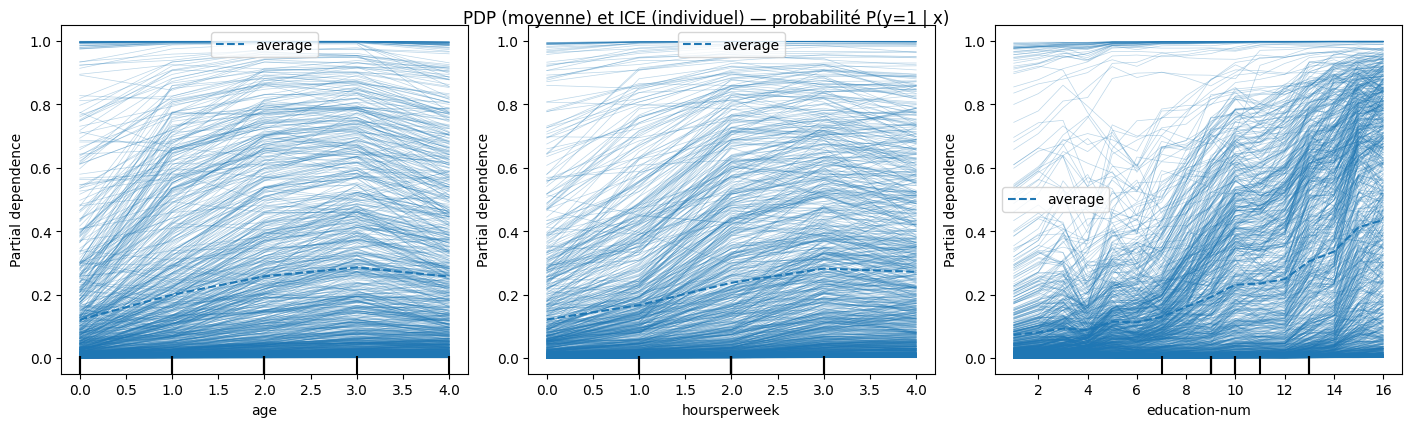

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_1d = ["age", "hoursperweek", "education-num"]

# kind="both" = PDP (moyenne) + ICE (individuel)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    pipe, X_test, features=features_1d,
    kind="both", grid_resolution=30, target=1, ax=ax
)
fig.suptitle("PDP (moyenne) et ICE (individuel) — probabilité P(y=1 | x)", y=1.03)
plt.show()

# PDP 2D (interactions)

In [ ]:
pairs_2d = [("age", "hoursperweek"),
            ("education-num", "hoursperweek")]

fig = plt.figure(figsize=(10, 8))
disp = PartialDependenceDisplay.from_estimator(
    pipe, X_test, features=pairs_2d,
    kind="average", grid_resolution=30, target=1
)
fig.suptitle("PDP 2D — interactions", y=1.02)
plt.show()

# ICE centré et hétérogénéité par sous-groupes (c-ICE + coloration)

/tmp/ipython-input-1533801247.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


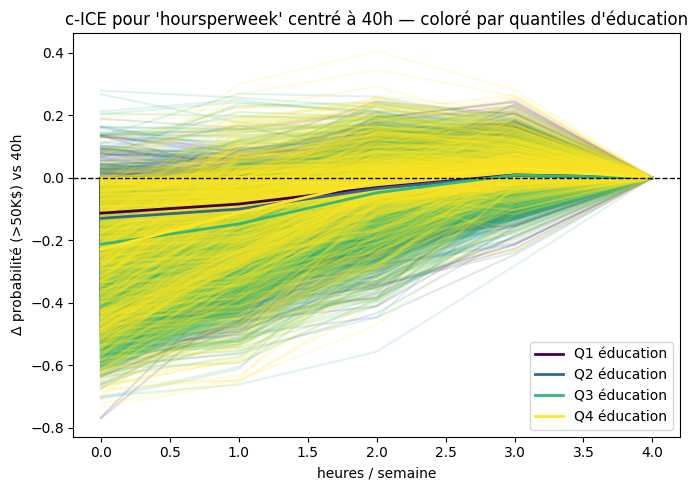

In [ ]:
from sklearn.inspection import partial_dependence

feat = "hoursperweek"
res = partial_dependence(
    pipe, X=X_test, features=[feat],
    kind="individual", grid_resolution=40
)
xs = res.grid_values[0]                 # grille
lines = res["individual"][0]          # (n_samples, len(xs))

# c-ICE: centre chaque courbe à 40h/semaine (ou au point médian le plus proche)
center_val = 40
center_idx = np.argmin(np.abs(xs - center_val))
lines_centered = lines - lines[:, [center_idx]]

# Colorer par quantiles d'"education-num" (hétérogénéité)
edu = X_test["education-num"].astype(float)
groups = pd.qcut(edu, q=5, labels=False, duplicates="drop")

plt.figure(figsize=(7, 5))
cmap = plt.cm.viridis
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].T, color=color, alpha=0.15)
# moyenne par groupe (plus lisible)
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].mean(axis=0), color=color, lw=2, label=f"Q{int(g)+1} éducation")
plt.axhline(0, color="k", lw=1, ls="--")
plt.title("c-ICE pour 'hoursperweek' centré à 40h — coloré par quantiles d'éducation")
plt.xlabel("heures / semaine"); plt.ylabel("Δ probabilité (>50K$) vs 40h")
plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
from sklearn.inspection import partial_dependence

feat = "hoursperweek"
res = partial_dependence(
    pipe, X=X_test, features=[feat],
    kind="individual", grid_resolution=40
)
xs = res.grid_values[0]                 # grille
lines = res["individual"][0]          # (n_samples, len(xs))

# c-ICE: centre chaque courbe à 0h/semaine (ou au point médian le plus proche)
center_val = 0
center_idx = np.argmin(np.abs(xs - center_val))
lines_centered = lines - lines[:, [center_idx]]

# Colorer par quantiles d'"education-num" (hétérogénéité)
edu = X_test["education-num"].astype(float)
groups = pd.qcut(edu, q=5, labels=False, duplicates="drop")

plt.figure(figsize=(7, 5))
cmap = plt.cm.viridis
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].T, color=color, alpha=0.15)
# moyenne par groupe (plus lisible)
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].mean(axis=0), color=color, lw=2, label=f"Q{int(g)+1} éducation")
plt.axhline(0, color="k", lw=1, ls="--")
plt.title("c-ICE pour 'hoursperweek' centré à 0h — coloré par quantiles d'éducation")
plt.xlabel("heures / semaine"); plt.ylabel("Δ probabilité (>50K$) vs 0h")
plt.legend()
plt.tight_layout(); plt.show()

# Variante rapide (régression California Housing)

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

In [ ]:
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
reg = Pipeline([
    ("prep", ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler())]),
         X.columns)
    ])),
    ("rf", RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1))
]).fit(X_train, y_train)

In [ ]:
features = ["MedInc", "AveOccup", "HouseAge"]
PartialDependenceDisplay.from_estimator(reg, X_test, features=features, kind="both", grid_resolution=30)
PartialDependenceDisplay.from_estimator(reg, X_test, features=[("MedInc","HouseAge")], kind="average", grid_resolution=30)
plt.show()

# Récapitulatif des Constats du Projet

Ce projet visait à entraîner un modèle non linéaire sur le dataset Adult Income, puis à utiliser les courbes PDP et ICE pour interpréter son comportement, en insistant sur la différence entre les effets moyens et individuels.

### Modèle Utilisé
Le modèle utilisé est un **XGBoost Classifier**, un modèle d'ensemble puissant et non linéaire, entraîné pour prédire la probabilité qu'un individu gagne plus de 50 000 $ par an.

### Variables Clés Analysées
Les variables clés sélectionnées pour l'analyse PDP et ICE, basées sur leur importance de permutation, sont :
- `age`
- `hoursperweek`
- `education-num`

### Insights des PDP/ICE 1D
- **`age`**: Le PDP a montré une relation non linéaire avec l'âge, avec une probabilité de gagner >50K augmentant initialement, se stabilisant, puis diminuant légèrement. Les courbes ICE individuelles ont révélé une grande variabilité autour de cette moyenne, suggérant que l'effet de l'âge est loin d'être uniforme pour tous les individus.
- **`hoursperweek`**: Le PDP a indiqué une augmentation de la probabilité avec les heures travaillées, atteignant un plateau autour de 40-45 heures, puis une légère baisse ou stabilisation. Les ICE ont montré des comportements très divers, avec certains individus présentant une forte augmentation linéaire, d'autres un plateau plus marqué, et d'autres encore une diminution rapide après le pic, masqués par la moyenne du PDP.
- **`education-num`**: Le PDP a révélé une relation globalement croissante entre le niveau d'éducation (numérique) et la probabilité de gagner >50K$. Les ICE ont également montré une forte hétérogénéité, certains individus ayant un effet d'éducation plus prononcé que d'autres, ou des seuils différents où la probabilité augmente significativement.

### Insights des PDP 2D (Interactions)
Les PDP 2D ont mis en évidence des interactions importantes entre les variables clés :
- **`age` et `hoursperweek`**: L'effet du nombre d'heures travaillées sur la probabilité de haut revenu dépend de l'âge. Par exemple, travailler plus d'heures peut avoir un impact plus prononcé ou différent sur les jeunes adultes en début de carrière par rapport aux travailleurs plus âgés, ou inversement, montrant que la combinaison de ces deux facteurs est plus informative que chacun pris isolément.
- **`education-num` et `hoursperweek`**: Une interaction claire a été observée où le bénéfice marginal d'heures supplémentaires est plus important ou se manifeste différemment selon le niveau d'éducation. Par exemple, pour les personnes avec une éducation supérieure, l'augmentation des heures de travail pourrait entraîner une augmentation plus forte de la probabilité de gagner >50K$ que pour celles avec un niveau d'éducation inférieur.

### Insights des c-ICE (centrés) et Coloration
L'analyse des c-ICE pour `hoursperweek`, centrés à 40 heures et colorés par les quantiles de `education-num`, a été particulièrement révélatrice de l'hétérogénéité :
- En centrant les courbes, nous avons pu mieux comparer les *pentes* et les *formes* des relations individuelles plutôt que leurs niveaux absolus.
- La coloration par `education-num` a clairement montré que l'effet de `hoursperweek` n'est pas uniforme mais varie considérablement en fonction du niveau d'éducation. Des groupes d'individus avec différents niveaux d'éducation (différentes couleurs) ont affiché des trajectoires très distinctes par rapport aux heures travaillées, prouvant que l'éducation agit comme un modérateur important de l'effet des heures. Ces différences auraient été complètement masquées par un PDP 1D seul.

### Conclusion Principale
Les **Partial Dependence Plots (PDP)** fournissent une excellente vue d'ensemble de l'effet moyen d'une ou deux variables sur la prédiction du modèle. Cependant, parce qu'ils agrègent les comportements, ils peuvent **lisser ou masquer des effets hétérogènes et des interactions complexes**. Les **Individual Conditional Expectation (ICE) plots**, en revanche, révèlent la diversité des comportements individuels du modèle. Lorsque les ICE sont **centrés (c-ICE)** ou **colorés par les valeurs d'une autre variable**, ils deviennent des outils puissants pour mettre en évidence les hétérogénéités, les interactions cachées et les différences de comportement selon les sous-groupes, ce qui est crucial pour une interprétation fine et nuancée des prédictions d'un modèle non linéaire.

## Summary:

### Data Analysis Key Findings
*   The project utilized an **XGBoost Classifier** to predict the probability of an individual earning over \$50,000 annually from the Adult Income dataset.
*   Key variables analyzed for model interpretation were `age`, `hoursperweek`, and `education-num`.
*   **1D PDP/ICE Analysis**:
    *   For `age`, the PDP showed a non-linear relationship (increasing, stabilizing, then slightly decreasing), while ICE plots revealed significant individual variability, indicating the effect of age is not uniform.
    *   For `hoursperweek`, PDP indicated an increase in probability up to 40-45 hours, followed by a slight decrease or stabilization. ICE plots displayed diverse individual behaviors, including linear increases, plateaus, and rapid declines after peaks, which were masked by the average PDP.
    *   For `education-num`, PDP showed a generally increasing relationship with higher income probability. ICE plots also highlighted strong heterogeneity, with varying educational impact across individuals.
*   **2D PDP Analysis**: Significant interactions were observed.
    *   The effect of `hoursperweek` on high income probability varied with `age`.
    *   The marginal benefit of additional hours worked differed based on `education-num`.
*   **c-ICE Analysis**: Centered ICE curves for `hoursperweek`, colored by `education-num` quantiles, revealed that the effect of working hours is not uniform but varies considerably based on the education level, acting as a significant moderator. This heterogeneity would be masked by 1D PDP.
*   **Main Conclusion**: Partial Dependence Plots (PDPs) provide an average view, which can smooth or hide heterogeneous effects and complex interactions. Individual Conditional Expectation (ICE) plots, especially when centered (c-ICE) or colored by other variables, are crucial for revealing individual-level variations, hidden interactions, and sub-group-specific behaviors, leading to a more nuanced model interpretation.

### Insights or Next Steps
*   Interpreting complex non-linear models like XGBoost requires a combination of global (PDP) and local/individual (ICE/c-ICE) explainability methods to fully understand both average trends and heterogeneous effects across different subgroups.
*   Further investigation could involve applying c-ICE analysis with different centering points or conditioning on other relevant features to explore additional multi-way interactions and understand the specific conditions under which certain individual effects are more pronounced.


# Define Top Features

Define the list of the top 3 most important features based on the `imp` series: `marital-status`, `capitalgain`, and `education-num`.


In [22]:
top_features = ['marital-status', 'capitalgain', 'education-num']
print(f"Top features defined: {top_features}")

Top features defined: ['marital-status', 'capitalgain', 'education-num']


## Define Top Features

### Subtask:
Define the list of the top 3 most important features (`marital-status`, `capitalgain`, and `education-num`) based on the permutation importance results (`imp` series).


### PDP et ICE 1D pour les Top 3 Features

Voici les Partial Dependence Plots (PDP) et Individual Conditional Expectation (ICE) plots pour les trois variables les plus importantes identifiées précédemment : `marital-status`, `capitalgain`, et `education-num`.

*   Pour `marital-status` (catégorielle), seul le PDP (courbe moyenne) est affiché car les ICE ne sont pas applicables.
*   Pour `capitalgain` et `education-num` (numériques), les courbes fines (ICE) montrent les effets individuels, tandis que la courbe épaisse représente l'effet moyen (PDP).

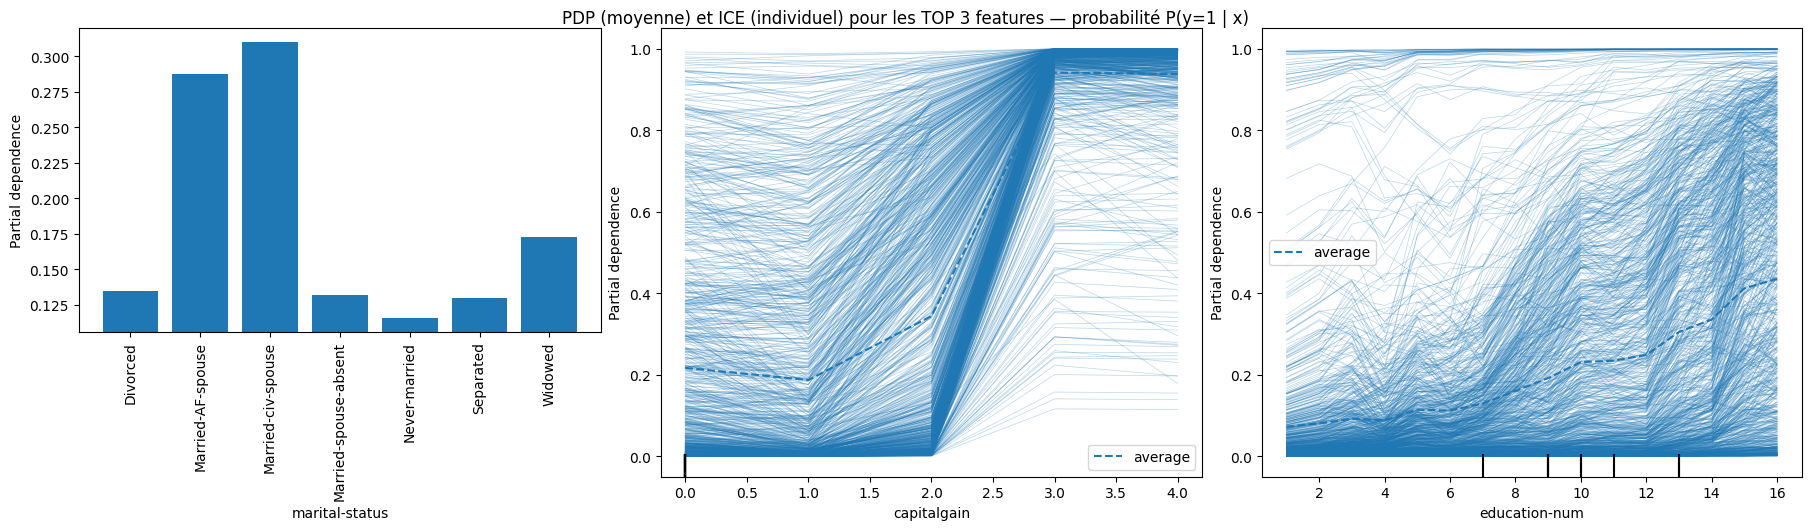

In [25]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd # Ensure pandas is imported for dtype checking

# top_features is already defined as ['marital-status', 'capitalgain', 'education-num']

# Separate categorical and numerical features from the top_features list
categorical_top_features = [f for f in top_features if isinstance(X_test[f].dtype, pd.CategoricalDtype)]
numerical_top_features = [f for f in top_features if not isinstance(X_test[f].dtype, pd.CategoricalDtype)]

# Create a figure with 3 subplots
fig, ax = plt.subplots(nrows=1, ncols=len(top_features), figsize=(18, 5), constrained_layout=True)

# Plot categorical features (PDP only)
for feat in categorical_top_features:
    idx = top_features.index(feat)
    PartialDependenceDisplay.from_estimator(
        pipe, X_test, features=[feat],
        kind="average", target=1, ax=ax[idx],
        categorical_features=[feat] # Explicitly declare as categorical
    )
    ax[idx].set_title(f"PDP for {feat} (Categorical)")

# Plot numerical features (PDP and ICE)
for feat in numerical_top_features:
    idx = top_features.index(feat)
    PartialDependenceDisplay.from_estimator(
        pipe, X_test, features=[feat],
        kind="both", grid_resolution=30, target=1, ax=ax[idx]
    )
    ax[idx].set_title(f"PDP & ICE for {feat} (Numerical)")

# Add a main title to the figure
fig.suptitle("PDP (moyenne) et ICE (individuel) pour les TOP 3 features — probabilité P(y=1 | x)", y=1.03)
plt.show()

### c-ICE pour 'capitalgain' coloré par les quantiles d''age'

Cette figure montre les courbes ICE centrées (c-ICE) pour la variable `capitalgain`. Chaque courbe individuelle représente l'effet de `capitalgain` sur la prédiction du modèle pour un individu, centrée à une valeur de `capitalgain` de 0. Les courbes sont colorées selon les quantiles d'âge de chaque individu, permettant d'observer comment l'effet du gain en capital peut varier en fonction de l'âge.

/tmp/ipython-input-3630652391.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


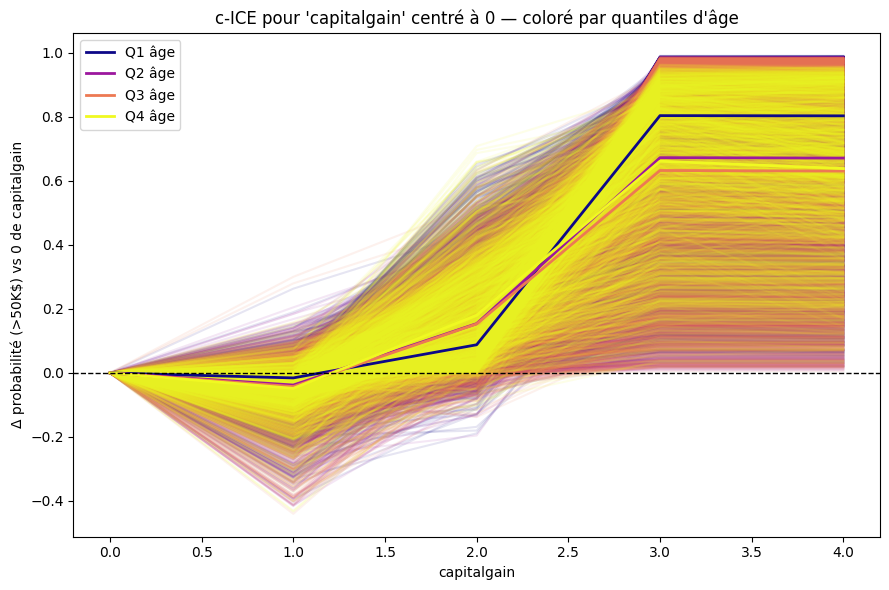

In [26]:
from sklearn.inspection import partial_dependence

feat_c_ice = "capitalgain"

res_c_ice = partial_dependence(
    pipe, X=X_test, features=[feat_c_ice],
    kind="individual", grid_resolution=40
)
x_c_ice = res_c_ice.grid_values[0]                 # grille
lines_c_ice = res_c_ice["individual"][0]          # (n_samples, len(xs))

# c-ICE: centre chaque courbe à une valeur de capitalgain de 0 (ou au point le plus proche)
center_val_c_ice = 0
center_idx_c_ice = np.argmin(np.abs(x_c_ice - center_val_c_ice))
lines_centered_c_ice = lines_c_ice - lines_c_ice[:, [center_idx_c_ice]]

# Colorer par quantiles d'"age"
age_values = X_test["age"].astype(float)
groups_age = pd.qcut(age_values, q=5, labels=False, duplicates="drop")

plt.figure(figsize=(9, 6))
cmap_age = plt.cm.plasma

for g in np.unique(groups_age):
    mask_age = (groups_age == g).values
    color_age = cmap_age(g / np.max(groups_age))
    plt.plot(x_c_ice, lines_centered_c_ice[mask_age].T, color=color_age, alpha=0.1)

# moyenne par groupe (plus lisible)
for g in np.unique(groups_age):
    mask_age = (groups_age == g).values
    color_age = cmap_age(g / np.max(groups_age))
    plt.plot(x_c_ice, lines_centered_c_ice[mask_age].mean(axis=0), color=color_age, lw=2, label=f"Q{int(g)+1} âge")

plt.axhline(0, color="k", lw=1, ls="--")
plt.title(f"c-ICE pour '{feat_c_ice}' centré à {center_val_c_ice} — coloré par quantiles d'âge")
plt.xlabel(feat_c_ice)
plt.ylabel(f"Δ probabilité (>50K$) vs {center_val_c_ice} de {feat_c_ice}")
plt.legend()
plt.tight_layout()
plt.show()

### PDP 2D : Interactions entre 'capitalgain' et 'education-num'

Cette carte 2D montre l'interaction entre le gain en capital (`capitalgain`) et le niveau d'éducation numérique (`education-num`). Elle illustre comment la probabilité de gagner plus de 50 000$ est conjointement influencée par ces deux variables, révélant des effets qui ne seraient pas visibles en examinant chaque variable séparément.

<Figure size 1000x800 with 0 Axes>

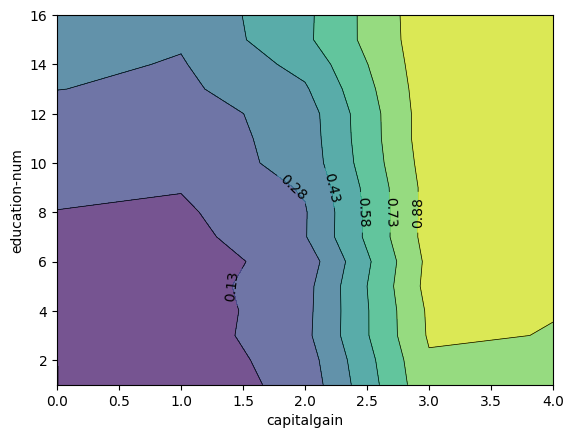

In [28]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

pairs_2d_top_num = [("capitalgain", "education-num")]

fig = plt.figure(figsize=(10, 8))
disp = PartialDependenceDisplay.from_estimator(
    pipe, X_test, features=pairs_2d_top_num,
    kind="average", grid_resolution=30, target=1
)
fig.suptitle("PDP 2D — interaction: capitalgain et education-num", y=1.02)
plt.show()